## Classification with Weighted Sampling
In this notebook, we will train the AlexNet model on our dataset. We will try to mitigate the class imbalance problem by stratified sampling from the dataset based on labels and weighted sampling.

In [27]:
!pip install git+https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git --no-deps

  Cloning https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git to /tmp/pip-req-build-etcq1cq7
  Running command git clone --filter=blob:none --quiet https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git /tmp/pip-req-build-etcq1cq7
  Resolved https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git to commit 8748a4539e22fbe769d3be918c793060f23c33b1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [28]:
import kagglehub
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import alexnet, vgg16
from torchvision.transforms import v2 as tfs

from exp_tools.basic_utils import init_module, plot_history
from exp_tools.data_utils import HAM10000Dataset, Explorer
from exp_tools.trainer import Trainer

### Loading the Dataset
First, we will load the HAM10000 dataset, both for training and validation.

In [29]:
batch_size = 32
image_size = (224, 224)
transform = tfs.Compose([
    tfs.ToImage(),
    tfs.Resize(image_size),
    tfs.ToDtype(torch.float32, scale=True)
])

In [30]:
local_path = "../data/HMNIST"
kaggle_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

train_set = HAM10000Dataset(
    dataset_dir=kaggle_path,
    transform=transform,
    target_transform=torch.tensor,
    split="train"
)
test_set = HAM10000Dataset(
    dataset_dir=kaggle_path,
    transform=transform,
    target_transform=torch.tensor,
    split="test"
)
print(f"Train samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")

Train samples: 8012
Test samples: 2003


#### Weighted Random Sampler
The following sampler class will give more priority to sample belonging to rare classes.

In [31]:
label_weights = 1 / train_set.sample_dist
sample_weights = [
    label_weights[train_set.label_map[label_str]].item()
    for label_str in train_set.metadata.dx
]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_set), replacement=True)

In [32]:
train_dl = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=2)
test_dl = DataLoader(test_set, batch_size=batch_size, num_workers=2)

### Preparing the Model
Now we are going to use AlexNet, a very old model but good for experimentation.

In [33]:
model = alexnet(weights=None, num_classes=len(train_set.label_map))
model.apply(init_module)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Training the Model
Now, we will train our model for possibly 20 epochs.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
metrics = {
    "accuracy": accuracy_score,
    "average_precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro", zero_division=0.0),
    "average_recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro", zero_division=0.0)
} # zero_division parameter is added because it is known that 
trainer = Trainer(
    max_epochs=5, device="cuda", clip_grad=True, clip_val=2.0, metrics=metrics
)

In [14]:
trainer.fit(model, criterion, optimizer, train_dl, test_dl)

Epoch 1/5
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 2.0787336365675486
Val loss: 1.9410446174015001
Epoch 2/5
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.978683761400517
Val loss: 1.9233503298823738
Epoch 3/5
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.9801650857306454
Val loss: 2.0217485642111783
Epoch 4/5
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 2.0035292848728923
Val loss: 2.053657016454193
Epoch 5/5
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 2.035693137692143
Val loss: 1.988425213934717


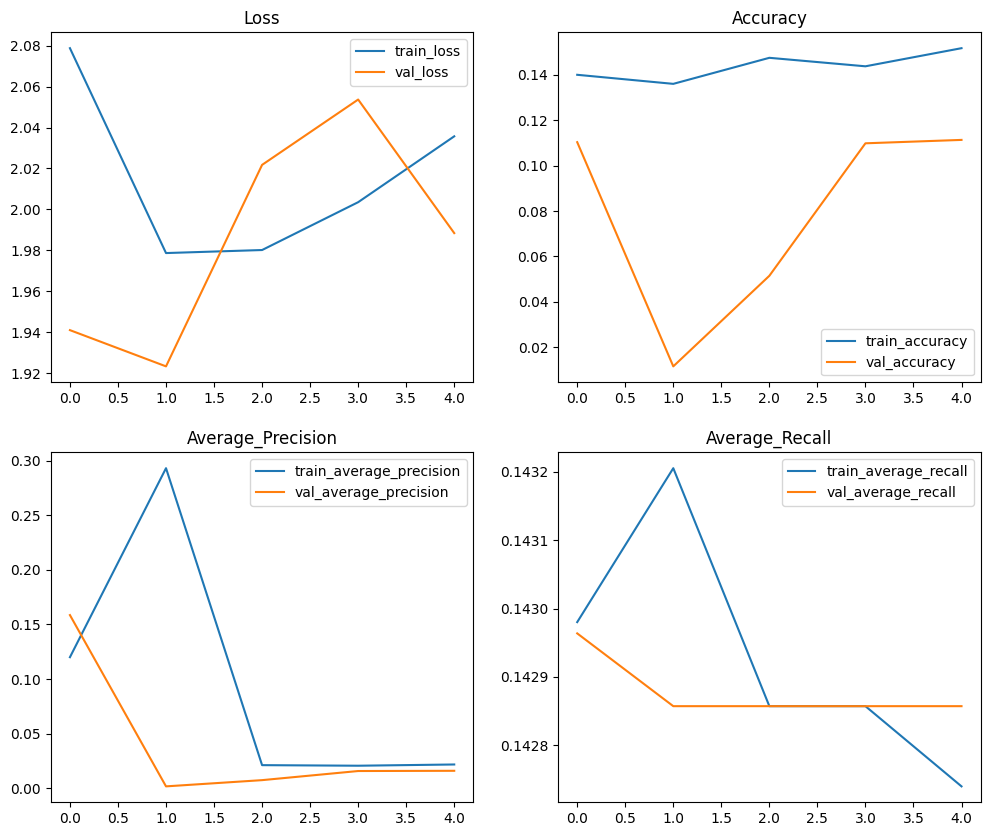

In [16]:
plot_history(trainer.current_history)

So, the results seem poor. Now, let's see whether using a bigger model such as vgg16 improves the results or not.

In [38]:
model = vgg16(weights=None, num_classes=len(train_set.label_map))
model.apply(init_module)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
metrics = {
    "accuracy": accuracy_score,
    "average_precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro", zero_division=0.0),
    "average_recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro", zero_division=0.0)
} # zero_division parameter is added because it is known that 
trainer = Trainer(
    max_epochs=10, device="cuda", clip_grad=True, clip_val=2.0, metrics=metrics
)

In [41]:
trainer.fit(model, criterion, optimizer, train_dl, test_dl)

Epoch 1/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 5832106304.561319
Val loss: 2.1865841173494807
Epoch 2/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.9905634809599717
Val loss: 2.1230021127747465
Epoch 3/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.9794935625431482
Val loss: 1.876412053555771
Epoch 4/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.9779070972860664
Val loss: 2.500007456442861
Epoch 5/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.979383167837241
Val loss: 1.8293695265926604
Epoch 6/10
[--------------------------------------------------] - batch: 251/251 - 100.00 complete
Train loss: 1.971887982433222
Val loss: 2.122993759673295
Epoch 7/10
[----------------------------------------

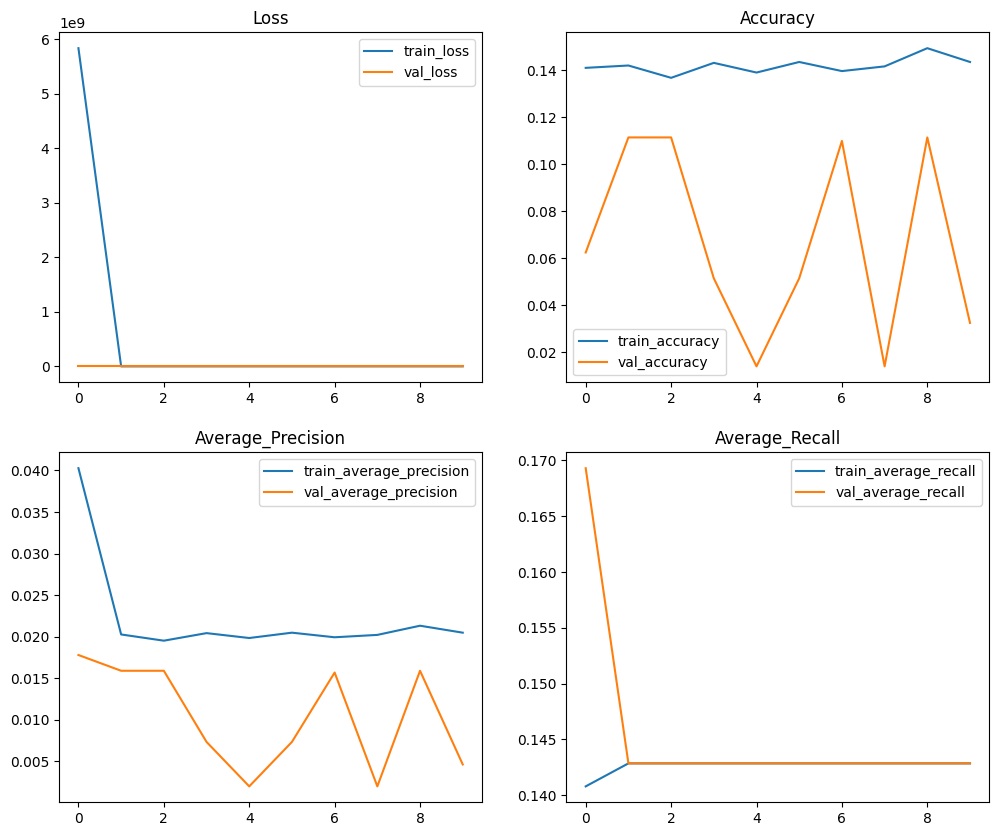

In [42]:
plot_history(trainer.current_history)